# Equivalent Layer technique for estimating magnetization direction of a magnetized sphere

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection.ipynb'

### Gray background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [6]:
import auxiliary_functions as fc

#### Loading properties of the model

In [7]:
with open('data/model_sphere_remanent.pickle') as f:
        model_sphere_remanent = pickle.load(f)

In [8]:
with open('data/model_sphere_induced.pickle') as f:
        model_sphere_induced = pickle.load(f)

#### Loading properties grid

In [9]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [10]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [11]:
dir_sphere = dict()

### Saving files

In [12]:
saved_files = []

## Observation area

In [13]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### Airborne survey information

In [14]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,20)
Number of data: 1000.0
dx: 204.1 m
dy: 526.3 m 


## Properties of the model

### Dimension and coordinate of the center

In [15]:
print 'Properties Sphere:\n xc = %.1f m \n yc = %.1f m \n zc = %.1f m \n radius = %.1f m ' %  (model_sphere_remanent['xc'],
                                                                                               model_sphere_remanent['yc'],
                                                                                               model_sphere_remanent['zc'],
                                                                                               model_sphere_remanent['radius'])

Properties Sphere:
 xc = 0.0 m 
 yc = 0.0 m 
 zc = 2000.0 m 
 radius = 1500.0 m 


### Main field

In [16]:
inc_gf,dec_gf = model_sphere_remanent['main_field']

In [17]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [18]:
print 'Intensity: %.1f A/m' % model_sphere_remanent['m_R']
print 'Inclination: %.1f degree' % model_sphere_remanent['inc_R']
print 'Declination: %.1f degree' % model_sphere_remanent['dec_R']

Intensity: 15.0 A/m
Inclination: 60.0 degree
Declination: 10.0 degree


In [19]:
inc_R,dec_R = model_sphere_remanent['inc_R'],model_sphere_remanent['dec_R']

## Generating the layer with my function 

In [20]:
h = 1900.

#### Generating a layer

In [21]:
shape_layer = (50,20)

In [22]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Non-negative Least Squares Method for estimating a positive layer

In [23]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,inc_R,dec_R)

In [24]:
start_time = timeit.default_timer()

In [25]:
m_pos,_ = nnls(G,data['tfa_obs_sphere_RM_airb'])

In [26]:
elapsed = timeit.default_timer() - start_time

In [27]:
print elapsed

0.37361907959


In [28]:
tf_pred_pos = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m_pos,inc_R,dec_R)

### Calculating residual

In [29]:
r_pos = data['tfa_obs_sphere_RM_airb'] - tf_pred_pos

#### Parameters for normalized histogram

In [30]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_RM_airb'],tf_pred_pos)

In [31]:
print r_mean

-0.343488036316


## Comparison between the Model and the Layer with posivity

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


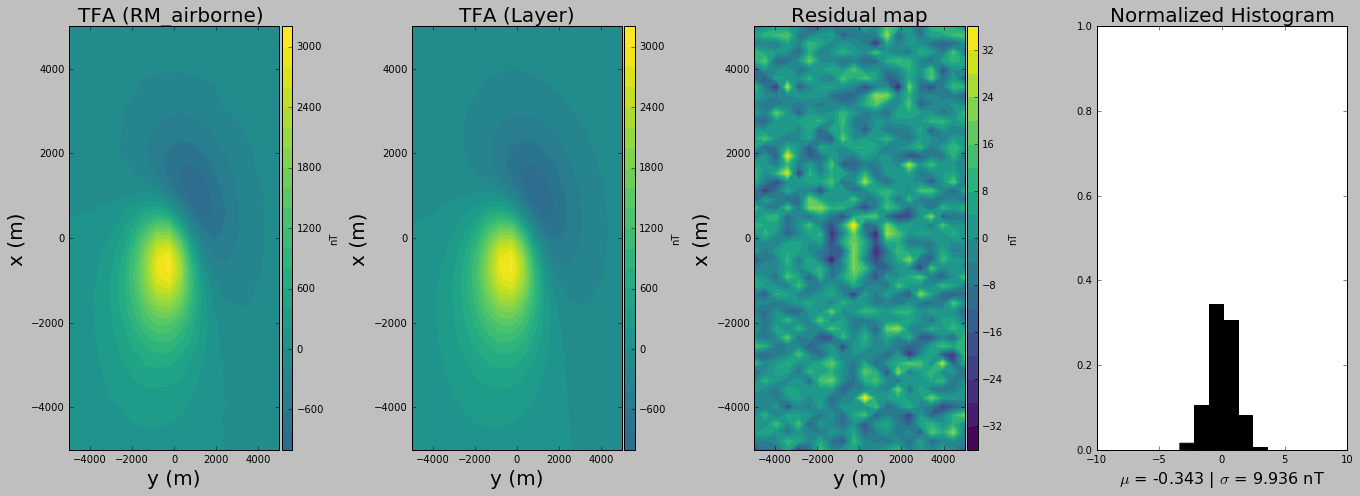

In [32]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(19,7), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   tf_pred_pos.max(), tf_pred_pos.min()]).max()

r_ranges = saturation_factor*np.abs([r_pos.max(), r_pos.min()]).max()

plt.subplot(1,4,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RM_airborne) ', fontsize=title_font)

plt.subplot(1,4,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             tf_pred_pos.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (Layer)', fontsize=title_font)

plt.subplot(1,4,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_pos.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)


plt.subplot(1,4,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('Normalized Histogram',fontsize=title_font)

file_name = 'figs/airborne/noisy_data_fitting_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Magnetic moment within the Layer with positivity constraint

<function matplotlib.pyplot.show>

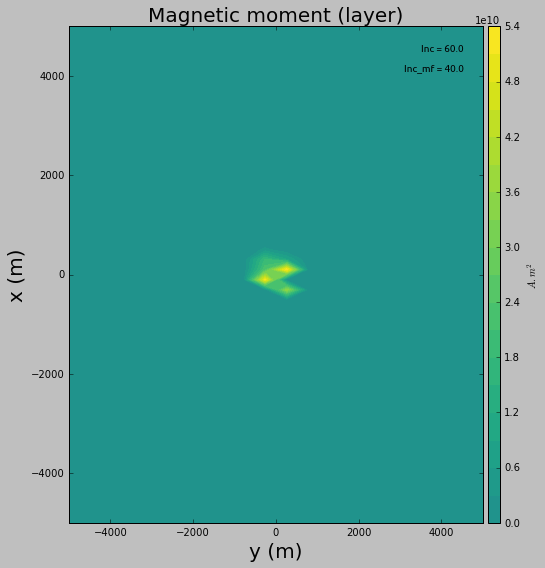

In [33]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

ranges = saturation_factor*np.abs([m_pos.max(), m_pos.min()]).max()

plt.contourf(ys.reshape(shape_layer),
             xs.reshape(shape_layer), 
             m_pos.reshape(shape_layer),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.text(3500.,4500.,'Inc = %.1f'% inc_R,family='ubuntu',style='normal')
plt.text(3100.,4100.,'Inc_mf = %.1f'% inc_gf,family='ubuntu',style='normal' )

file_name = 'figs/airborne/noisy_magnetic_moment_positive_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [34]:
i_pos = 1500

In [35]:
it_max = 30

In [36]:
it_marq = 15

In [37]:
eps = 1e-4

In [38]:
lamb = 10.
dlamb = 100.

In [39]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_sphere_RM_airb'],airborne['x'],airborne['y'],airborne['z'],
    xs,ys,zs,inc_gf,dec_gf,-60.,60.,lamb,dlamb,i_pos,it_max,
    it_marq,eps)

i = 0
-40.5862522424 35.0977417973
0.0209440148236
i = 1
-12.0947695935 34.651796346
0.149879588181
i = 2
4.36992269981 37.824536646
0.831037346529
i = 3
8.33776905401 39.2351312511
0.401724315163
i = 4
10.7586990629 39.6991778618
0.210305199246
i = 5
12.690933596 39.8941819898
0.14759738902
i = 6
14.1847793452 39.9773713106
0.113268930639
i = 7
15.5266646199 39.9966361443
0.093092163867
i = 8
16.6884370486 39.9503330659
0.0795320697657
i = 9
17.6722858321 39.8630430881
0.0696060729394
i = 10
18.5726717373 39.746456067
0.0625157756358
i = 11
19.402785811 39.6161368813
0.0567783601013
i = 12
20.2109974131 39.4758445607
0.0515488611475
i = 13
20.9478364001 39.3294980743
0.0465969915694
i = 14
21.6235874385 39.1767121042
0.0422064653776
i = 15
22.2474876614 39.0259590263
0.0383258652398
i = 16
22.8277100607 38.8828408365
0.0349684823604
i = 17
23.336260497 38.7425172851
0.032431917469
i = 18
23.8226275682 38.6008068147
0.0304579907563
i = 19
24.287849192 38.4565895165
0.0286295263407
i = 

### Visualization of the convergence

In [40]:
phi = np.array(phi)/airborne['x'].size

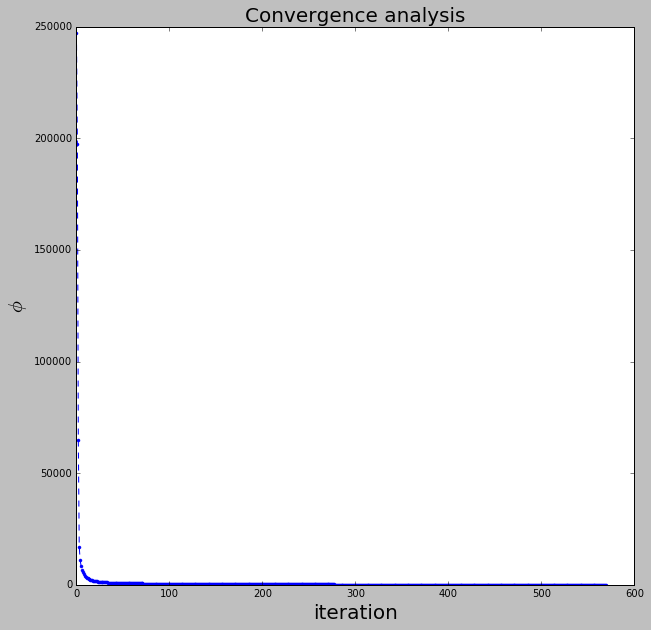

In [41]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)

file_name = 'figs/airborne/noisy_convergence_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Estimated magnetization direction

In [42]:
print (inc_est,dec_est)

(58.748902701905216, 13.207224536355634)


In [43]:
print (inc_R,dec_R)

(60.0, 10.0)


### Comparison between observed data and predicted data

In [44]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [45]:
res = pred - data['tfa_obs_sphere_RM_airb']

In [46]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_RM_airb'],pred)

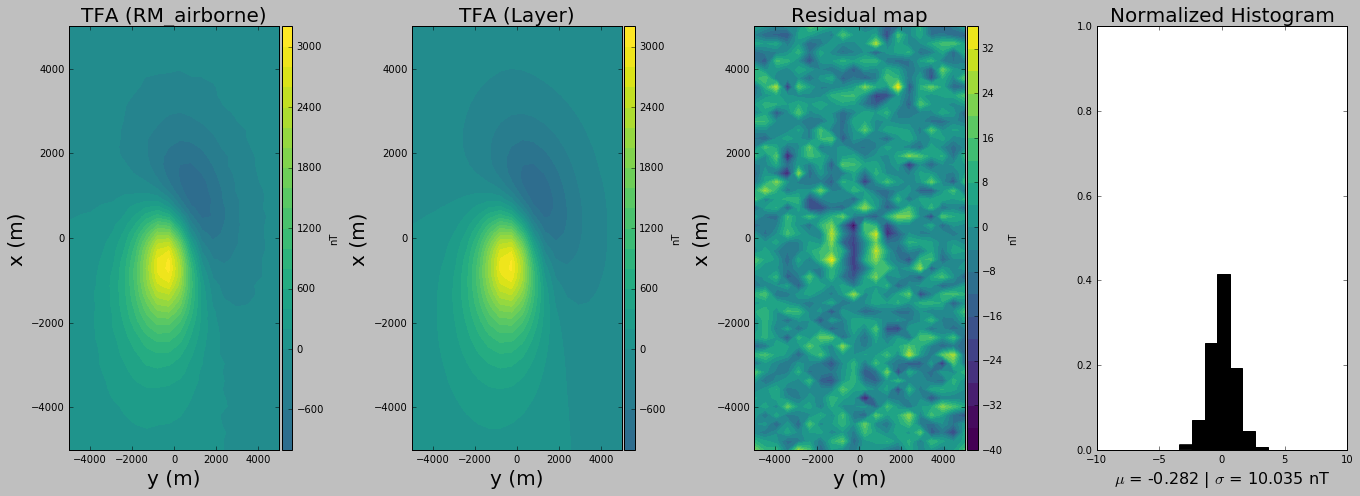

In [47]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(19,7), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(1,4,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RM_airborne)',fontsize=title_font)

plt.subplot(1,4,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (Layer)', fontsize=title_font)

plt.subplot(1,4,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)


plt.subplot(1,4,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('Normalized Histogram',fontsize=title_font)

file_name = 'figs/airborne/noisy_data_fitting_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Estimated magnetic moment within the layer

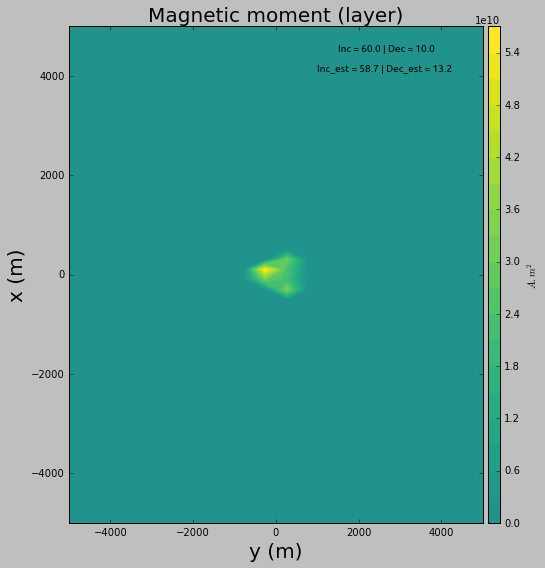

In [48]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

ranges = saturation_factor*np.abs([m_LM.max(), m_LM.min()]).max()

plt.contourf(ys.reshape(shape_layer),
             xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.text(1500.,4500.,'Inc = %.1f | Dec = %.1f '% (inc_R,dec_R),family='ubuntu',style='normal')
plt.text(1000.,4100.,'Inc_est = %.1f | Dec_est = %.1f '% (inc_est,dec_est),family='ubuntu',style='normal' )

file_name = 'figs/airborne/noisy_magnetic_moment_positive_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Reduction to the pole

In [49]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [50]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

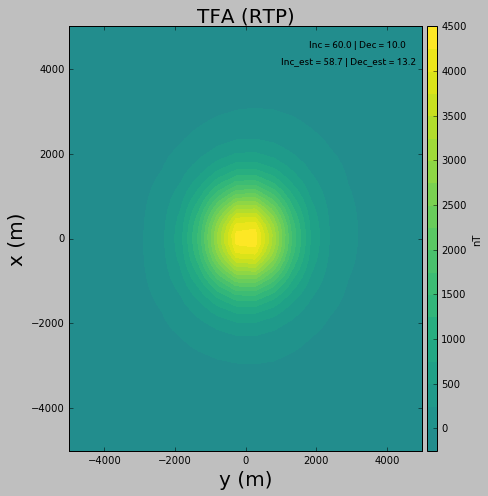

In [51]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

ranges = saturation_factor*np.abs([tfa_rtp.max(), tfa_rtp.min()]).max()

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.text(1800.,4500.,'Inc = %.1f | Dec = %.1f'% (inc_R,dec_R), 
         family='ubuntu',style='normal')
plt.text(1000.,4100.,'Inc_est = %.1f | Dec_est = %.1f'% (inc_est,dec_est), 
         family='ubuntu',style='normal' )


file_name = 'figs/airborne/RTP_airborne_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')


plt.show()